In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! pip install torch_utils

  Created wheel for torch-utils: filename=torch_utils-0.1.2-cp36-none-any.whl size=6191 sha256=eae0ac234bd20678aa63859cd530d81a3c5d91333ea04e7bf1a9f820c71c952c
  Stored in directory: /root/.cache/pip/wheels/95/61/06/139d254fa820bc1e45087dba1d719bc7d4007aec98905179c7
Successfully built torch-utils


In [1]:
%cd gdrive/My\ Drive/Colab\ Notebooks/Case_Study_2

/content/gdrive/My Drive/Colab Notebooks/Case_Study_2


In [2]:
# import modules
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data Preprocessing

In [3]:
# import data
creditcard = pd.read_csv('Credit-Card-Dataset/Credit-card-dataset/creditcard.csv/creditcard.csv')

#separate features and labels
X = creditcard.iloc[:,0:30]
y = creditcard.iloc[:,-1]

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(data = X_test)

ros_50_50 = RandomOverSampler(sampling_strategy='minority')
X_balanced, y_balanced = ros_50_50.fit_resample(X_train, y_train)
X_balanced = pd.DataFrame(data = X_balanced)
y_balanced = pd.DataFrame(data = y_balanced)

X_train, X_validation, y_train, y_validation = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [4]:
to_use = list(range(0,30))

# training set: n = 800
train_X = torch.tensor(X_train.values).float()
train_Y = torch.tensor(y_train.values).long()

# validation set
validation_X = torch.tensor(X_validation.values).float()
validation_Y = torch.tensor(y_validation.values).long()

# prediction set
test_X = torch.tensor(X_test.values).float()

In [5]:
train_Y = torch.flatten(train_Y)
validation_Y = torch.flatten(validation_Y)

### Baseline Model

In [6]:
#device = torch.device("cuda")
device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} 
# prepare training data loader
train_ds = TensorDataset(train_X,train_Y)
validate_ds = TensorDataset(validation_X,validation_Y)

batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True,**kwargs)

validate_dl = DataLoader(validate_ds, batch_size, shuffle=True,**kwargs)

# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        self.fc1 = nn.Linear(input_d,hidden_d)
        self.fc2 = nn.Linear(hidden_d,hidden_d)
        self.fc3 = nn.Linear(hidden_d,output_d)
        #self.dropout1 = nn.Dropout(0.5)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        #out = self.dropout1(out)
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return torch.sigmoid(out)

# define dimensions
input_d = len(to_use)
hidden_d = 1
output_d = 2

# set up the model
model = bmodel(input_d, hidden_d, output_d).to(device)

# define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-4)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define the training function
def train(train_loader,model,device,loss_fn,opt):
    model.train()

    losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        #targets = targets.unsqueeze(dim=0)
        
        # generate predictions
        pred = model(inputs)
        
        loss = loss_fn(pred, targets)

        # record loss
        losses.update(loss.data.item())

        # perform gradient descent
        opt.zero_grad()
        loss.backward()
        opt.step()

    return losses.avg

# define the validation function
def validate(val_loader, model, device, loss_fn):
    model.eval()
    with torch.no_grad():
        losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

        for batch_idx, (inputs,targets) in enumerate(val_loader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            #targets = targets.unsqueeze(1)
            outputs = model(inputs)
            loss = loss_fn(outputs , targets)

            losses.update(loss.data.item())

    return losses.avg

# define the main function
def fit(num_epochs, model, loss_fn, opt):

    best_loss = 1e9
    is_best = False
    out_train_loss = []
    out_validate_loss = []

    for epoch in range(1,num_epochs+1):
        train_loss = train(train_dl,model,device,loss_fn,opt)
        validation_loss = validate(validate_dl, model,device, loss_fn)

        is_best = validation_loss < best_loss
        best_loss = min(validation_loss,best_loss)

        out_train_loss.append(train_loss)
        out_validate_loss.append(validation_loss)

        if is_best:
            torch.save(model.state_dict(), 'data/best_nn.pt')

        if epoch % 5 == 0:
            print("[%d/%d] training loss: %0.3f, validation loss: %.3f"
                  % (epoch,num_epochs,train_loss,validation_loss))

    print("Best validation loss (%.03f): %.03f" % (epoch,best_loss))
    return out_train_loss, out_validate_loss

In [8]:
out_train_loss, out_validate_loss = fit(10, model, loss_fn, opt)

[5/10] training loss: 0.701, validation loss: 0.702
[10/10] training loss: 0.700, validation loss: 0.700
Best validation loss (10.000): 0.700


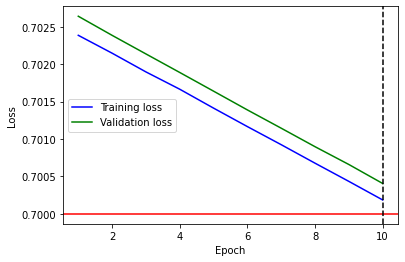

In [9]:
# plot the training and validation loss: rmse
plot_data = {'Epoch': list(range(1,11)),
             'TrainLoss': [x for x in out_train_loss],
             'ValidateLoss': [x for x in out_validate_loss] }

plot_data = pd.DataFrame(plot_data)

# find the best epoch
index_min = plot_data['ValidateLoss'].idxmin()

# plot
plt.plot('Epoch','TrainLoss',data=plot_data,color="blue",label='Training loss')
plt.plot('Epoch','ValidateLoss',data=plot_data,color="green",label='Validation loss')
plt.axhline(y=0.7, color='red', linestyle='-')
plt.axvline(x=index_min+1, color='k', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# prediction in the validation set
model.load_state_dict(torch.load('data/best_nn.pt'))
model.eval()
with torch.no_grad():
    preds = model(validation_X.cpu()) 

ans = []
#Pick the class with maximum weight
for t in preds:
  if t[0]>t[1]:
    ans.append(0)
  else:
    ans.append(1)

In [19]:
con_mat = confusion_matrix(validation_Y, ans)
acc = accuracy_score(validation_Y, ans)
print("Accuracy Score: %.3f" % (acc))

Accuracy Score: 0.940


In [23]:
con_mat[1][0] /(con_mat[1][0] + con_mat[1][1])

0.10168264484566615

In [12]:
preds

tensor([[0.5663, 0.2983],
        [0.5663, 0.2983],
        [0.5663, 0.2983],
        ...,
        [0.7804, 0.3800],
        [0.5663, 0.2983],
        [0.5663, 0.2983]])

In [ ]:
# calibration plot of the validation set
plt.plot( (validation_Y).detach().numpy(), preds.cpu().numpy(), 'o')
plt.xlabel('Targeted y', fontsize=16)
plt.ylabel('Modeled y', fontsize=16)
plt.ylim(1e5,8e5)
plt.xlim(1e5,8e5)
plt.show()

In [ ]:
class Classifier(nn.module):
  def __init__(self):
    super(MyClassifier,self).__init__()
    